In [151]:
# Fix RTL in nbviewer
from IPython.display import HTML
HTML("<style>.jp-RenderedMarkdown { direction: rtl;} .jp-RenderedMarkdown p { text-align: right;}</style>")

# סיווג סרטים באמצעות ניתוח סנטימנטלי
#### פרוייקט סופי במסגרת סדנה במדעי הנתונים
**מגיש**: איתם יוגב

## הקדמה

המטרה שלי בפרוייקט היא ניתוח סנטימנטלי של סצנות סרטים, וניסיון לקישור בין רמות הסנטימנטים לאורך הסרט ובין סיווג הז'אנרים של הסרט. המשימה של סיווג סרטים לז'אנרים נראית פשוטה ממבט ראשון אך היא אינה טריוויאלית, שכן לא ניתן להסיק אותה באופן מיידי ממידע כלשהו על הסרט, והיא מצריכה ידע רחב ותושמת לב לדקויות. כמו כן, ז'אנר הוא אינו מאפיין בודד אחד, ובדרך כלל סרט יכול להשתייך לכמה ז'אנרים, וגם זה במידות שונות.

הרבה חברות סטרימינג גדולות כמו נטפליקס משתמשות בסיווג ז'אנרים כדי לזהות דמיון בין תכנים, וכך לתת למשתמש הצעות שיותר יתאימו לטעמו. קיימות שיטות רבות לסיווג ז'אנרים בעזרת למידת מכונה המשתמשות למשל בכותרת הסרט, תיאור הסרט טריילר ועוד.

בפרוייקט שלי אבחן את הרעיון של סנטימנטים במשפטים מתוך הסרט כבעלי קורלציה לז'אנרים של הסרט. ניתוח התוכן עצמו של הסרט מאתגר יותר מאשר ניתוח נתונים נלווים, אך הוא מאפשר ניתוח מעמיק יותר והתייחסות לפרטים נוספים חשובים כמו ציר הזמן, הדמויות השונות, עוצמת הרגש וכו' מה שלא ניתן כאשר מנתחים למשל את התקציר. בנוסף מציאת קורלציה בין סנטימנטים וז'אנרים יכולה לעבוד גם בכיוון ההפוך - בהינתן סרט בעל ז'אנר מסויים, תהיה אפשרות להגיד מהן התכונות של הדיאלוגים במהלך הסרט שעלינו לחפש בסרט מסוג זה.

### אתגרים ומגבלות מהותיות

הרבה מהדיאלוגים בסרט הם בעלי סאבטקסט וטונים שלא ניתן לחלץ מתוך הטקסט לבדו

## נתונים

מאגר הנתונים שבחרתי עבור הפרויקט הוא מאגר דיאלוגים בסרטים של אוניב' קורנל, שנמצא ב- 
[Kaggle](https://www.kaggle.com/datasets/Cornell-University/movie-dialog-corpus)

המאגר מכיל מידע טקסטואלי שחולץ מ-617 תסריטי סרטים באנגלית, ו-304,713 משפטים שנאמרו בסרטים. עבור כל סרט הוא מכיל מידע על השורות שנאמרו, אילו שורות שייכות לאותו דיאלוג או שיחה בסרט, על ידי מי נאמרה השורה ומיהן הדמויות בסרט. כמו כן לכל סרט יש מידע שנלקח מIMDB המכיל גם את הז'אנרים.

נבצע טעינה של הטבלאות ל-DataFrames של pandas.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
meta_cols = ['movie_id', 'title', 'year', 'rating', 'no. votes', 'genres']
meta = pd.read_table(
    './datasets/movie-dialog-corpus/movie_titles_metadata.tsv', sep='\t', header=None, names=meta_cols, index_col='movie_id')

In [35]:
meta.sample(5)

,title,year,rating,no. votes,genres
movie_id,,,,,
m177,shock treatment,1981,5.4,1884,['comedy' 'musical']
m529,star wars,1977,8.8,326619,['action' 'adventure' 'fantasy' 'sci-fi']
m150,nixon,1995,7.1,13878,['biography' 'drama']
m151,no country for old men,2007,8.3,202649,['crime' 'drama' 'mystery' 'thriller' 'western']
m579,toy story,1995,8.2,156231,['animation' 'adventure' 'comedy' 'family' 'fa...


עבור הטבלאות movie_lines ו-movie_conversations, מבחינה ראשונית נראה שיש שורות בפורמט לא תקין. בחרתי לוותר על שורות אלו (עם `on_bad_lines=skip`). 

In [5]:
line_cols = ['line_id', 'character_id', 'movie_id', 'character_name', 'text']
lines = pd.read_table('./datasets/movie-dialog-corpus/movie_lines.tsv', sep='\t',
                      header=None, names=line_cols, index_col='line_id', on_bad_lines='skip')

conv_cols = ['first_char', 'second_char', 'movie_id', 'line_ids']
convos = pd.read_table(
    './datasets/movie-dialog-corpus/movie_conversations.tsv', sep='\t', header=None, names=conv_cols, on_bad_lines='skip')

## עיבוד מקדים

בטבלת הסרטים (meta) עמודת הז'אנרים היא string מהצורה ['comedy' 'musical']. נמיר את הנתונים בעמודה ל-list: 

In [6]:
def str_to_list(str: str):
    s = str.strip('\'[]')
    return list(set(s.split("\' \'") if s else []))

meta['genre_list'] = meta.genres.apply(str_to_list)

אם נבחן את את טיב הנתונים בטבלת השורות, נראה כי קיימות שורות ללא טקסט או המכילות תווים מיוחדים (נובע מהבדלים ב-encoding):

In [59]:
print(lines.loc['L24609'].text)
print(lines.loc['L34851'].text)
print(lines.loc['L523286'].text)

nan
I'm sorry Dude butI
You know what? Im not having this conversation right now.


לכן ראשית נבצע preprocessing כדי לטייב את הטקסטים: 

In [7]:
import re

def preprocess_text(text):
    return re.sub('\x92', "'", re.sub('\x97', ' - ', re.sub('<.+>', ' ', text)))

lines = lines.dropna()
lines['text_pp'] = lines.text.apply(preprocess_text)

In [65]:
print(lines.loc['L34851'].text_pp)
print(lines.loc['L523286'].text_pp)

I'm sorry Dude but - I - 
You know what? I'm not having this conversation right now.


## EDA

### ניתוח בסיסי 

ראשית ננתח את פיזור כמות השיחות בכל סרט:

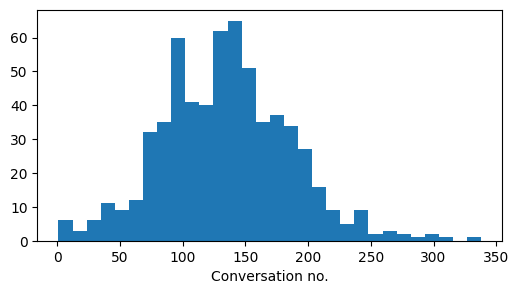

In [29]:
fig, axes = plt.subplots(1, 1, figsize=(6,3))

axes.hist(convos.groupby('movie_id').count().line_ids, bins=30)
axes.set_xlabel('Conversation no.')

plt.show()

מפיזור כמויות השיחות בסרטים ניתן ללמוד כי מספר השיחות בכל סרט משתנה, וכי ברוב הסרטים יש בין 100 ל-200 שיחות. כמו כן נראה שיש סרטים עם מספר שיחות קטן מאוד (< 50), כלומר המידע לגביהם חסר או לא רלוונטי. נצטרך להתחשב בפערים אלו כאשר נבצע עיבוד לנתונים בהמשך.

כעת נבחן את פיזור הז'אנרים המשויכים לסרטים:

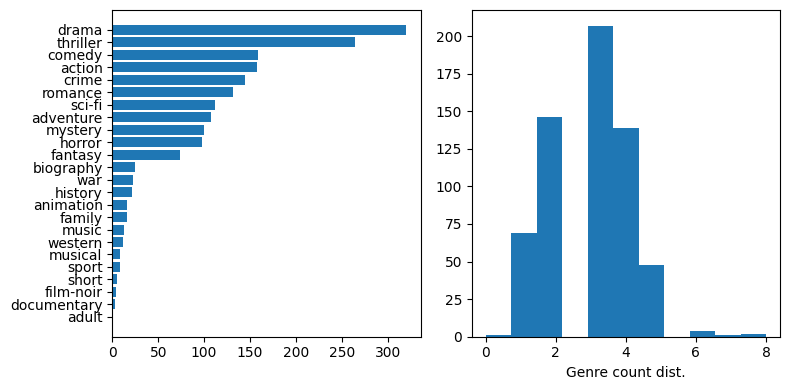

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(8,4), tight_layout=True)

genre_counts = meta.explode('genre_list').genre_list.value_counts()

axes[0].barh(genre_counts.index, genre_counts.values)
axes[0].invert_yaxis()

axes[1].hist(meta.genre_list.apply(len), bins=11)
axes[1].set_xlabel('Genre count dist.')

plt.show()

הגרף משמאל מראה את כמות הסרטים בכל ז'אנר, והגרף מימין מראה את פיזור כמות הז'אנרים המשוייכים לכל סרט. מגרפים אלו ניתן ללמוד כמה דברים:
1. קיימים הבדלים מהותיים בין שלושה קבוצות של ז'אנרים:
    - דרמה ומתח הם הז'אנרים הפופולריים ביותר, ושניהם נמצאים במספר גדול מאוד של סרטים. עובדה זו הגיונית כיוון שדרמה ומתח הם כלליים יותר משאר הז'אנרים, אך ייתכן וכלליות זו תפגע ביכולת שלנו לסווג את הסרטים בצורה מדויקת בהמשך.
    - הקבוצה השנייה היא קבוצת הז'אנרים הסטנדרטית (אקשן, קומדיה וכו') שרוב הסרטים משוייכים לאחד מהז'אנרים בה
    - הקבוצה השלישית היא קבוצת ז'אנרים המינורים, שהם יותר ספציפיים ולא משותפים למספר גדול של סרטים. מקבוצה זו ככל הנראה נתעלם כאשר נרצה לאמן מודל לסיווג ז'אנרים.
2. רוב הסרטים משוייכים ל-3-5 ז'אנרים, אך קיימים סרטים שלהם 6-8 ז'אנרים או ז'אנר אחד.
    - מיעוט בז'אנרים יכול להביא לתוצאות פחות מדויקות, ומדובר בפער הקיים במאגר הנתונים (בפועל לסרטים אלו יש ז'אנרים נוספים) 
    - ריבוי ז'אנרים יכול להיות טוב, אך בפועל הז'אנרים הנוספים כנראה הם כאלו מינוריים שפחות מאפיינים באופן מהותי את הסרט, ולכן פחות רלוונטיים. 

### ניתוח טקסט בסיסי

כדי שנוכל לנתח את הטקסטים של הסרטים בנפרד, נגדיר פונקציות עזר שיחזירו  

In [12]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from lexical_diversity import lex_div as ld

def sample_genre(genre, n):
    return meta[meta.genre_list.apply(lambda x: genre in x)].sample(n)

STOP_WORDS = set(stopwords.words('english'))

def is_word(string: str):
    return string.isalpha() and string.lower() not in STOP_WORDS


def tokenize(text):
    return [w for w in word_tokenize(text) if is_word(w)]

def lexical_diversity(text):
    return ld.msttr(tokenize(text))


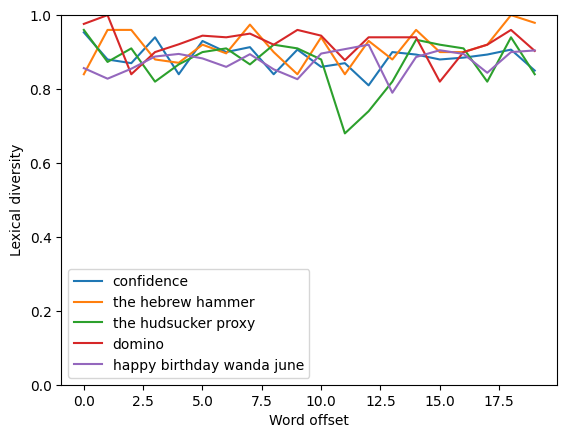

In [69]:
for mid, s in meta.sample(5).iterrows():
    texts = movie_texts(mid).to_list()
    data = [lexical_diversity(' '.join(ts)) for ts in np.array_split(texts, 20)]
    plt.plot(data, label=s['title'])
plt.legend()
plt.xlabel('Word offset') 
plt.ylabel('Lexical diversity') 
plt.ylim(0, 1)
plt.show()

In [125]:
    
def movie_texts(movie_id) -> pd.Series:
    return lines[lines['movie_id'] == movie_id].text_pp

def genre_texts(genre, n):
    movies = sample_genre(genre, n)
    print(genre)
    print(movies.title)
    return lines.join(movies, on="movie_id", how="inner").text_pp


In [153]:
from nltk.text import Text

crime_text = Text(tokenize(' '.join(genre_texts('crime', 5))))
comedy_text = Text(tokenize(' '.join(genre_texts('comedy', 5))))
horror_text = Text(tokenize(' '.join(genre_texts('horror', 5))))

crime
movie_id
m204    the talented mr. ripley
m262                     batman
m597                 virtuosity
m203              the godfather
m280                      bones
Name: title, dtype: object
comedy
movie_id
m103    it happened one night
m570              three kings
m269         the big lebowski
m467             out of sight
m51        drop dead gorgeous
Name: title, dtype: object
horror
movie_id
m514                                      the shining
m410                    the lost world: jurassic park
m7      a nightmare on elm street 4: the dream master
m470                                  pet sematary ii
m421                                        leviathan
Name: title, dtype: object


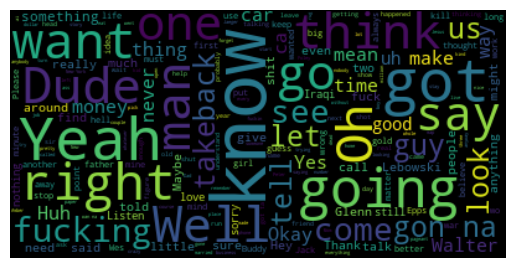

In [154]:
from wordcloud import WordCloud

wordcloud = WordCloud(max_font_size=60).generate(' '.join(comedy_text.tokens)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.show()

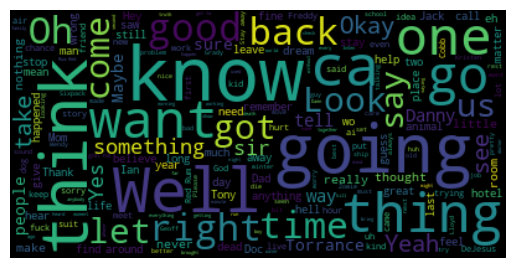

In [155]:
wordcloud = WordCloud(max_font_size=60).generate(' '.join(horror_text.tokens)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.show()

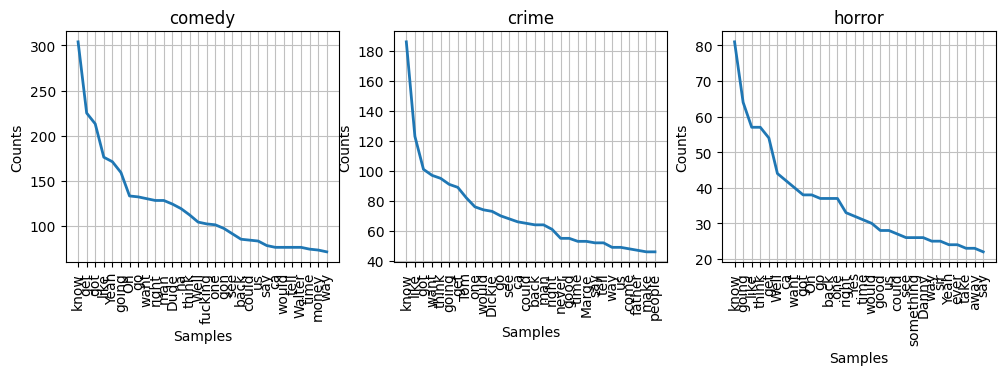

In [156]:
from nltk import FreqDist

plt.subplots(1, 3, figsize=(12, 3))
plt.subplot(131)
ax = FreqDist(comedy_text).plot(30, show=False)
ax.set_title("comedy")

plt.subplot(132)
ax = FreqDist(crime_text).plot(30, show=False)
ax.set_title("crime")

plt.subplot(133)
ax = FreqDist(horror_text).plot(30, show=False)
ax.set_title("horror")
plt.show()

In [131]:
def dispersion_plot(text, words, ax, ignore_case=True):
    text = list(text)
    words.reverse()

    if ignore_case:
        words_to_comp = list(map(str.lower, words))
        text_to_comp = list(map(str.lower, text))
    else:
        words_to_comp = words
        text_to_comp = text
    points = [
        (x, y)
        for x in range(len(text_to_comp))
        for y in range(len(words_to_comp))
        if text_to_comp[x] == words_to_comp[y]
    ]
    if points:
        x, y = list(zip(*points))
    else:
        x = y = ()
    ax.plot(x, y, "b|", scalex=0.1)
    plt.yticks(list(range(len(words))), words, color="b")
    plt.ylim(-1, len(words))
    plt.xlabel("Word Offset")


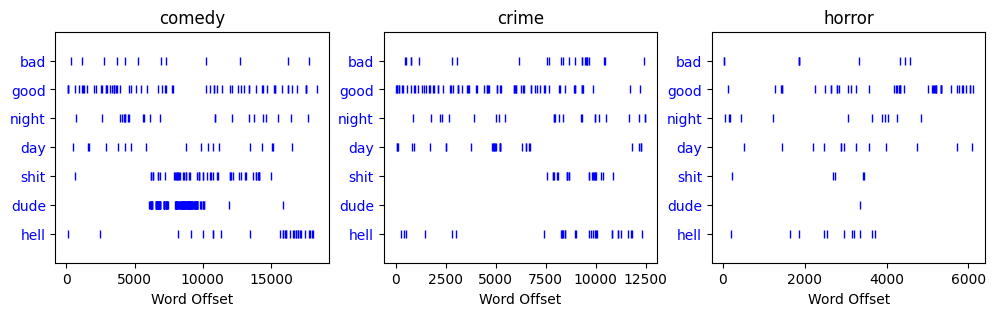

In [170]:
words = ["bad", "good", "night", "day", "shit", "dude", "hell"]

plt.subplots(1, 3, figsize=(12, 3))

ax = plt.subplot(131)
dispersion_plot(comedy_text, words.copy(), ax)
ax.set_title("comedy")

ax = plt.subplot(132)
dispersion_plot(crime_text, words.copy(), ax)
ax.set_title("crime")

ax = plt.subplot(133)
dispersion_plot(horror_text, words.copy(), ax)
ax.set_title("horror")
plt.show()


In [169]:
horror_text.concordance("get")

Displaying 25 of 57 matches:
ead feet know Maybe working much want get stuck waiting tables rest life know h
st life know hardly time study got ta get library closes Killer physics test hu
 hell Something wrong feels like know get weirdest feeling going Debbie got ta 
ke meet Debbie tonight least sleep ca get us else Yeah right Let trade death Fr
 wo see ca ca talk authorities really get nightstalker take bench presses beat 
 people killed Freddy Maybe Freddy ca get new kids without someone like Someone
ller freed technicality miss Let talk get Excuse ladies moment Hey Rick Earth A
rn Something wrong stairs worry honey get stay put need rest got ta get nasty b
y honey get stay put need rest got ta get nasty bump Yeah guess happened Feelin
 bother trying convince use checkbook get fund expedition personal accounts mon
ged Greenpeace corporate stooge could get anybody else head InGen really workin
 night put bus morning mother station get Kelly Hi Dad Let go Peter animal move
ly Come kno

In [55]:
meta.loc['m126'].genre_list

['action', 'drama', 'crime', 'animation', 'mystery', 'sci-fi', 'thriller']

In [56]:
meta[meta.genre_list.apply(lambda x: len(x) <= 1)][['title', 'genre_list']]

,title,genre_list
movie_id,,
m18,american madness,[drama]
m32,black snake moan,[drama]
m64,friday the 13th,[horror]
m69,george washington,[drama]
m83,hardcore,[drama]
...,...,...
m580,the magic toyshop,[fantasy]
m588,u-turn,[drama]
m593,verdict,[drama]


## סיווג בעזרת TF-IDF


## אלגוריתם ניתוח סנטימנטלי

כפי שהזכרתי, המרכיב המרכזי שברצוננו לבחון הוא הקשר בין עוצמת הסנטימנטים לאורך סרט לבין הז'אנרים שלו. כדי לחלץ את המידע על הסנטימנטים מתוך הטקסט, נשתמש באלגוריתם ניתוח סנטימנטלי המבוסס על NLP. קיים מגוון רחב של אלגוריתמים שמבצעים משימה זו, אך האלגוריתם צריך לענות על כמה תנאים:
- האלגוריתם צריך להתמודד עם משפטים מורכבים הכוללים שלילה, שאלות וכו'. אלגוריתמים של למידה מפוקחת כמו אלו המסתמכים על מילה או מילים ספציפיות, לא יתנו מענה טוב כיוון שהם פשוטים ולא אומדים בניואנסים של דיאלוג בסרט
- האלגוריתם צריך לנתח מספר סנטימנטים, ולתת יותר מידע מחיובי/שלילי. זאת כדי לתת מענה לסיווג הז'אנרים נדרשת כמות גדולה יותר של פיצ'רים
- האלגוריתם צריך להיות בצורת מודל מאומן, כיוון שהמידע שברשותנו לא מאפשר אימון מודל חדש עבור ניתוח סנטימנטלי

לשם כך ה

### חלוקה לדיאלוגים

לא ניתן לבצע ניתוח סנטימנטלי ראליסטי לתוכנו של הסרט ללא חלוקה כלשהי, שכן ניתוח של הסרט בשלמותו הוא ארוך מדי ודורש מודל מסוג אחר, וכן מאבד את מימד הזמן. מצד שני ניתוח בנפרד של כל משפט בסרט יכול לקחת הרבה זמן. לכן החלוקה של סרט לדיאלוגים כפי שנמצאת במאגר מתאימה למטרתנו.

למרות החלוקה לדיאלוגים, עדיין עלינו להגביל את אורך הטקסט שאנו מעבירים למודל, כיוון שהמודל מוגבל למספר מסויים של קלטים. לאחר ניסוי וטעייה הגעתי למספר 1400 שהוא האורך המקסימלי של הקלט שאותו אנתח. באופן כללי הגבלת אורך הטקסט תצמצם את מרווח הטעייה ותחזק את תוצאת הניתוח.

### חילוץ סנטימנטים 

### סיווג בעזרת מודלים בסיסיים 

### חילוץ פיצ'רים מתקדם

## קלאסטרינג עם TimeSeries


### עיבוד מקדים

### אלגוריתם K-Means